In [ ]:
FOLDER = "/bean/depth/09-04-19-40-39/19_41_55_570"

import os
import cv2

import numpy as np


img_rgb = cv2.imread(FOLDER + "/rgb/left.png", cv2.IMREAD_COLOR_RGB) / 255.0
img_nir =   cv2.imread(FOLDER + "/nir/left.png", cv2.IMREAD_GRAYSCALE) / 255.0


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(img_nir, cmap='gray')
plt.show()

In [ ]:
def get_pixel_gradient(img, kernel_size=1):
    
    img = img.astype(np.float32)
    print(img.shape)
    grad_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=kernel_size)
    grad_y = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=kernel_size)
    if img.ndim == 2:
        grad_x = grad_x[:, :, np.newaxis]
        grad_y = grad_y[:, :, np.newaxis]
    grad_x = grad_x[:, :, :, np.newaxis]
    grad_y = grad_y[:, :, :, np.newaxis]
    
    #grad_x = np.clip(grad_x, -255, 255)
    #grad_y = np.clip(grad_y, -255, 255)
    grad = np.concatenate((grad_x, grad_y), axis=3)
     # H x W x C x 2
    
    return grad

def compute_gradient(img):
    # 이미지의 모양을 확인 (h, w, c)
    if len(img.shape) == 2 :
        img = img[:, :, np.newaxis]
    h, w, c = img.shape
    
    # 결과를 담을 배열을 생성 (h, w, c, 2) -> 2는 x축과 y축 gradient를 담기 위함
    gradients = np.zeros((h, w, c, 2))
    
    # 각 채널에 대해 gradient를 계산
    for channel in range(c):
        # y축과 x축의 gradient를 계산 (np.gradient는 첫 번째 축을 y, 두 번째 축을 x로 본다)
        grad_y, grad_x = np.gradient(img[:, :, channel])
        
        grad_x[0,0] = img[0,0,channel]
        grad_y[0,0] = img[0,0,channel]
        # x축과 y축의 gradient를 각각 저장
        gradients[:, :, channel, 0] = grad_x  # x축 gradient
        gradients[:, :, channel, 1] = grad_y  # y축 gradient
        
        
    
    return gradients

# grad_rgb = get_pixel_gradient(img_rgb, kernel_size=11)
# grad_nir = get_pixel_gradient(img_nir, kernel_size=11)
grad_rgb = compute_gradient(img_rgb)
grad_nir = compute_gradient(img_nir)
print(grad_rgb.shape, grad_nir.shape)
print(grad_rgb.min(), grad_rgb.max(), grad_rgb.mean(), np.median(grad_rgb))
    

In [ ]:
def jacobian_matrix(input):
    input_t = np.transpose(input, (0, 1, 3, 2))
    result = np.matmul(input_t, input)
    return result

jacobian_rgb = jacobian_matrix(grad_rgb)
jacobian_nir = jacobian_matrix(grad_nir)

In [69]:
import numpy as np

def batch_matrix_sqrt(matrices):
    # 2x2 행렬의 고유값 분해 (벡터화)
    eigenvalues, eigenvectors = np.linalg.eig(matrices)
    
    # 고유값의 제곱근을 계산
    sqrt_eigenvalues = np.sqrt(eigenvalues)
    
    # 고유값들을 대각 행렬로 변환 (벡터화 처리)
    sqrt_diag = np.einsum('...ij,...j->...ij', eigenvectors, sqrt_eigenvalues)
    
    # 행렬의 제곱근 계산: V * sqrt(D) * V^-1
    sqrt_matrices = np.matmul(sqrt_diag, np.linalg.pinv(eigenvectors))
    
    return sqrt_matrices

def compute_gradient_weight(src: np.ndarray, dest: np.ndarray):
    # src와 dest는 hxw의 차원을 가진 2x2 행렬들로 구성된 배열
    src = src.astype(np.complex64)
    dest = dest.astype(np.complex64)
    
    # 1. 각 2x2 행렬에 대해 제곱근 계산 (벡터화 처리)
    src_sqrt = batch_matrix_sqrt(src)
    dest_sqrt = batch_matrix_sqrt(dest)
    
    # 2. src_sqrt의 유사역행렬 계산 (벡터화 처리)
    src_inv = np.linalg.pinv(src_sqrt)
    
    # 3. src_sqrt와 dest_sqrt의 행렬 곱 및 고유값 분해 (벡터화 처리)
    product = np.matmul(src_sqrt, np.transpose(dest_sqrt, axes=(0, 1, 3, 2)))
    e_val, e_vec = np.linalg.eig(product)
    
    # 4. 고유값 대각행렬 및 고유벡터를 사용하여 o 행렬 계산 (벡터화 처리)
    # `np.diag()` 대신 고유값을 대각 행렬로 변환하는 벡터화된 방식을 사용

    e_vec = e_vec / np.linalg.norm(e_vec, axis=-1, keepdims=True)

    o = e_vec


    result = np.matmul(np.matmul(src_inv, o), dest_sqrt)
    
    return result


weight = compute_gradient_weight(jacobian_rgb, jacobian_nir)
print(weight.shape, weight.min(), weight.max())

(540, 720, 2, 2) (-20792.139-4721.167j) (62371.84+14158.446j)


In [ ]:
grad_rgb_new = np.matmul(grad_rgb, weight)
#grad_rgb_new = np.clip(grad_rgb_new, -100, 100)
print(grad_rgb_new.shape, grad_rgb_new.dtype, grad_rgb_new.min(), grad_rgb_new.max())


In [ ]:
fig = plt.figure(figsize=(10,10))
cx = plt.imshow(grad_rgb_new[:,:,0,0].real, cmap='jet', vmin=-0.01, vmax=0.01)
plt.colorbar(cx)
plt.show()

In [ ]:

def reconstruct_image(grad_matrix):
    # grad_matrix는 h x w x 3 x 2 크기의 numpy 배열
    h, w, c, _ = grad_matrix.shape
    img = np.zeros((h, w, c), dtype=np.complex128)  # 복원할 이미지 (h x w x 3)

    # 채널 별로 복원
    for channel in range(c):
        
        gx = grad_matrix[:, :, channel, 0]  # x 방향 gradient
        gy = grad_matrix[:, :, channel, 1]  # y 방향 gradient
        # 첫번째 행은 x 축 적분 (누적합)
        
        img[0, :, channel] = np.cumsum(gx[0, :])[:w] # + img_rgb[0,0,channel]
        img[:, 0, channel] = np.cumsum(gy[:, 0])[:h] # + img_rgb[0,0,channel]
        # 두번째 행부터는 누적합을 이용하여 이미지 복원

        for i in range(1, h):
            for j in range(1, w):
                ix = img[i, j-1, channel] + gx[i, j] 
                iy = img[i-1, j, channel] + gy[i, j]
                # print(img[i-1, j, channel], gx[i, j])
                # print(img[i, j-1, channel], gy[i, j])
                # print(">", ix, iy)
                # print("=", np.sqrt((ix**2 + iy**2)/2))
                img[i, j, channel] = np.sqrt((ix**2 + iy**2)/2)
    img = np.real(img)
    return img

rgb_new = reconstruct_image(grad_rgb_new)

print(rgb_new.shape, rgb_new.dtype, rgb_new.min(), rgb_new.max(), rgb_new.mean(), np.median(rgb_new))
#rgb_new /= np.max(rgb_new)
print(rgb_new.shape, rgb_new.dtype, rgb_new.min(), rgb_new.max(), rgb_new.mean(), np.median(rgb_new))
#rgb_new = np.clip(rgb_new, 0, 255)
plt.figure(figsize=(10,10))
plt.imshow(rgb_new)
plt.show()


In [ ]:
from tqdm import tqdm
import torch


def poisson_reconstruct_torch(
    gradients, boundary_conditions, iterations=2000, tol=1e-5, device="cuda"
):
    """
    Poisson reconstruction using gradient information with PyTorch and GPU acceleration.

    Args:
    - gradients: hxwx3x2 tensor containing the gradients (∂I/∂x, ∂I/∂y) for R, G, B channels
    - boundary_conditions: hxwx3 tensor containing boundary conditions (initial guess of image)
    - iterations: number of iterations for the reconstruction process (default: 2000)
    - tol: tolerance for convergence (default: 1e-5)
    - device: 'cuda' for GPU, 'cpu' for CPU

    Returns:
    - reconstructed_image: hxwx3 tensor, the reconstructed image
    """

    # Move tensors to the specified device (GPU/CPU)
    if isinstance(gradients, np.ndarray):
        gradients = torch.from_numpy(gradients).float()
        
        if len(boundary_conditions.shape) == 2:
            boundary_conditions = boundary_conditions[:, :, np.newaxis]
            boundary_conditions = np.repeat(boundary_conditions, 3, axis=2)
        
        boundary_conditions = torch.from_numpy(boundary_conditions).float()
    gradients = gradients.to(device)
    boundary_conditions = boundary_conditions.to(device)

    h, w, c = boundary_conditions.shape
    reconstructed_image = boundary_conditions.clone()

    # Prepare masks for the interior of the image
    mask_x = torch.zeros((h, w), device=device)
    mask_x[1:-1, 1:-1] = 1

    # Main iteration loop for Jacobi method
    for iteration in tqdm(range(iterations)):
        prev_image = reconstructed_image.clone()

        for channel in range(3):  # Process each channel (R, G, B)
            # Extract the gradients for the current channel
            grad_x = gradients[:, :, channel, 0]
            grad_y = gradients[:, :, channel, 1]

            # Compute the divergence of the gradients ∇·grad
            div_grad = torch.zeros((h, w), device=device)
            div_grad[1:-1, 1:-1] = (grad_x[1:-1, 1:-1] - grad_x[1:-1, :-2]) + (
                grad_y[1:-1, 1:-1] - grad_y[:-2, 1:-1]
            )

            # Jacobi update: use previous image and gradients to compute new values
            reconstructed_image[1:-1, 1:-1, channel] = 0.25 * (
                prev_image[1:-1, :-2, channel]
                + prev_image[1:-1, 2:, channel]
                + prev_image[:-2, 1:-1, channel]
                + prev_image[2:, 1:-1, channel]
                - div_grad[1:-1, 1:-1]
            )

        # Check for convergence based on the L2 norm of the difference between iterations
        diff = torch.norm(reconstructed_image - prev_image)
        if diff < tol:
            print(f"Converged after {iteration + 1} iterations.")
            break

    return reconstructed_image


reconstructed_image = (
    poisson_reconstruct_torch(grad_rgb_new, img_nir, iterations=200000).cpu().numpy()
)
print(
    reconstructed_image.shape,
    reconstructed_image.dtype,
    reconstructed_image.min(),
    reconstructed_image.max(),
    reconstructed_image.mean(),
    np.median(reconstructed_image),
)
plt.figure(figsize=(10, 10))
reconstructed_image = reconstructed_image.real

plt.imshow(reconstructed_image)

In [ ]:
import torch


def poisson_reconstruct_sor(gradients, boundary_conditions, iterations=2000, omg = 1.5, tol=1e-5):
    """
    Poisson reconstruction using gradient information.

    Args:
    - gradients: hxwx3x2 numpy array containing the gradients (∂I/∂x, ∂I/∂y) for R, G, B channels
    - boundary_conditions: hxwx3 numpy array containing boundary conditions (initial guess of image)
    - iterations: number of iterations for the reconstruction process (default: 2000)
    - tol: tolerance for convergence (default: 1e-5)

    Returns:
    - reconstructed_image: hxwx3 numpy array, the reconstructed image
    """
    if len(boundary_conditions.shape) == 2:
        boundary_conditions = boundary_conditions[:, :, np.newaxis]
        boundary_conditions = np.repeat(boundary_conditions, 3, axis=2)
    h, w, c = boundary_conditions.shape
    # Initialize the reconstructed image with boundary conditions (e.g. original image or zeros)
    reconstructed_image = boundary_conditions.copy().astype(np.complex128)

    # Perform iterative Poisson reconstruction for each channel
    for iteration in tqdm(range(iterations)):
        prev_image = reconstructed_image.copy()

        for channel in range(3):  # For each R, G, B channel
            # Compute divergence of the gradient (∇·grad) for the current channel
            grad_x = gradients[:, :, channel, 0]
            grad_y = gradients[:, :, channel, 1]

            div_grad = np.zeros((h, w)).astype(np.complex128)
            div_grad[1:-1, 1:-1] = (grad_x[1:-1, 1:-1] - grad_x[1:-1, :-2]) + (grad_y[1:-1, 1:-1] - grad_y[:-2, 1:-1])

            # Update the image using the Poisson equation and the divergence
            reconstructed_image[1:-1, 1:-1, channel] = (1 - omg) * prev_image[1:-1, 1:-1, channel] + omg * 0.25 * (
                reconstructed_image[1:-1, :-2, channel] +
                reconstructed_image[1:-1, 2:, channel] +
                reconstructed_image[:-2, 1:-1, channel] +
                reconstructed_image[2:, 1:-1, channel] -
                div_grad[1:-1, 1:-1]
            )

        # Check for convergence
        if np.linalg.norm(reconstructed_image - prev_image) < tol:
            print(f"Converged after {iteration} iterations.")
            break

    return reconstructed_image


reconstructed_image = (
    poisson_reconstruct_sor(grad_rgb_new, img_nir, iterations=100, omg = 1.03)
)
print(
    reconstructed_image.shape,
    reconstructed_image.dtype,
    reconstructed_image.min(),
    reconstructed_image.max(),
    reconstructed_image.mean(),
    np.median(reconstructed_image),
)
plt.figure(figsize=(10, 10))
reconstructed_image = reconstructed_image.real

plt.imshow(reconstructed_image)

In [ ]:

import torch
from tqdm import tqdm
def poisson_reconstruct_gauss_seidel(gradients, boundary_conditions, iterations=2000, tol=1e-5, device='cuda'):
    """
    Poisson reconstruction using gradient information with PyTorch and GPU acceleration (Gauss-Seidel method).

    Args:
    - gradients: hxwx3x2 tensor containing the gradients (∂I/∂x, ∂I/∂y) for R, G, B channels
    - boundary_conditions: hxwx3 tensor containing boundary conditions (initial guess of image)
    - iterations: number of iterations for the reconstruction process (default: 2000)
    - tol: tolerance for convergence (default: 1e-5)
    - device: 'cuda' for GPU, 'cpu' for CPU

    Returns:
    - reconstructed_image: hxwx3 tensor, the reconstructed image
    """
    
        # Move tensors to the specified device (GPU/CPU)
    if isinstance(gradients, np.ndarray):
        gradients = torch.from_numpy(gradients)
        
        if len(boundary_conditions.shape) == 2:
            boundary_conditions = boundary_conditions[:, :, np.newaxis]
            boundary_conditions = np.repeat(boundary_conditions, 3, axis=2)
        
        boundary_conditions = torch.from_numpy(boundary_conditions)
    gradients = gradients.to(device)
    boundary_conditions = boundary_conditions.to(device)


    h, w, c = boundary_conditions.shape
    reconstructed_image = boundary_conditions.clone()

    # Prepare masks for red-black updates (checkerboard pattern)
    red_mask = torch.zeros((h, w), dtype=torch.bool, device=device)
    black_mask = torch.zeros((h, w), dtype=torch.bool, device=device)
    
    # Red-black checkerboard pattern
    red_mask[1:h:2, 1:w:2] = True  # Odd rows, odd columns
    red_mask[2:h:2, 2:w:2] = True  # Even rows, even columns
    
    black_mask[1:h:2, 2:w:2] = True  # Odd rows, even columns
    black_mask[2:h:2, 1:w:2] = True  # Even rows, odd columns

    # Main iteration loop for Red-Black Gauss-Seidel method
    for iteration in tqdm(range(iterations)):
        prev_image = reconstructed_image.clone()

        for channel in range(3):  # Process each channel (R, G, B)
            # Extract the gradients for the current channel
            grad_x = gradients[:, :, channel, 0]
            grad_y = gradients[:, :, channel, 1]

            # Compute the divergence of the gradients ∇·grad
            div_grad = torch.zeros((h, w), device=device)
            div_grad[1:-1, 1:-1] = (grad_x[1:-1, 1:-1] - grad_x[1:-1, :-2]) + (grad_y[1:-1, 1:-1] - grad_y[:-2, 1:-1])

            # Update red points (first half of the checkerboard)
            red_indices = red_mask.nonzero(as_tuple=True)
            valid_mask = (red_indices[0] > 0) & (red_indices[0] < h-1) & (red_indices[1] > 0) & (red_indices[1] < w-1)
            valid_red_indices = (red_indices[0][valid_mask], red_indices[1][valid_mask])

            reconstructed_image[valid_red_indices[0], valid_red_indices[1], channel] = 0.25 * (
                reconstructed_image[valid_red_indices[0], valid_red_indices[1] - 1, channel] +  # Left
                reconstructed_image[valid_red_indices[0], valid_red_indices[1] + 1, channel] +  # Right
                reconstructed_image[valid_red_indices[0] - 1, valid_red_indices[1], channel] +  # Above
                reconstructed_image[valid_red_indices[0] + 1, valid_red_indices[1], channel] -  # Below
                div_grad[valid_red_indices[0], valid_red_indices[1]]
            )

            # Update black points (second half of the checkerboard)
            black_indices = black_mask.nonzero(as_tuple=True)
            valid_mask = (black_indices[0] > 0) & (black_indices[0] < h-1) & (black_indices[1] > 0) & (black_indices[1] < w-1)
            valid_black_indices = (black_indices[0][valid_mask], black_indices[1][valid_mask])

            reconstructed_image[valid_black_indices[0], valid_black_indices[1], channel] = 0.25 * (
                reconstructed_image[valid_black_indices[0], valid_black_indices[1] - 1, channel] +  # Left
                reconstructed_image[valid_black_indices[0], valid_black_indices[1] + 1, channel] +  # Right
                reconstructed_image[valid_black_indices[0] - 1, valid_black_indices[1], channel] +  # Above
                reconstructed_image[valid_black_indices[0] + 1, valid_black_indices[1], channel] -  # Below
                div_grad[valid_black_indices[0], valid_black_indices[1]]
            )

        # Check for convergence based on the L2 norm of the difference between iterations
        diff = torch.norm(reconstructed_image - prev_image)
        if diff < tol:
            print(f"Converged after {iteration + 1} iterations.")
            break

    return reconstructed_image


reconstructed_image = (
    poisson_reconstruct_gauss_seidel(grad_rgb_new, img_nir, iterations=500)
).cpu().numpy()
print(
    reconstructed_image.shape,
    reconstructed_image.dtype,
    reconstructed_image.min(),
    reconstructed_image.max(),
    reconstructed_image.mean(),
    np.median(reconstructed_image),
)
plt.figure(figsize=(10, 10))
reconstructed_image = reconstructed_image.real

plt.imshow(reconstructed_image)

(540, 720, 3)
(540, 720)


100%|██████████| 10000/10000 [00:46<00:00, 216.84it/s]


(540, 720, 3)
(540, 720)


100%|██████████| 10000/10000 [00:45<00:00, 220.28it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


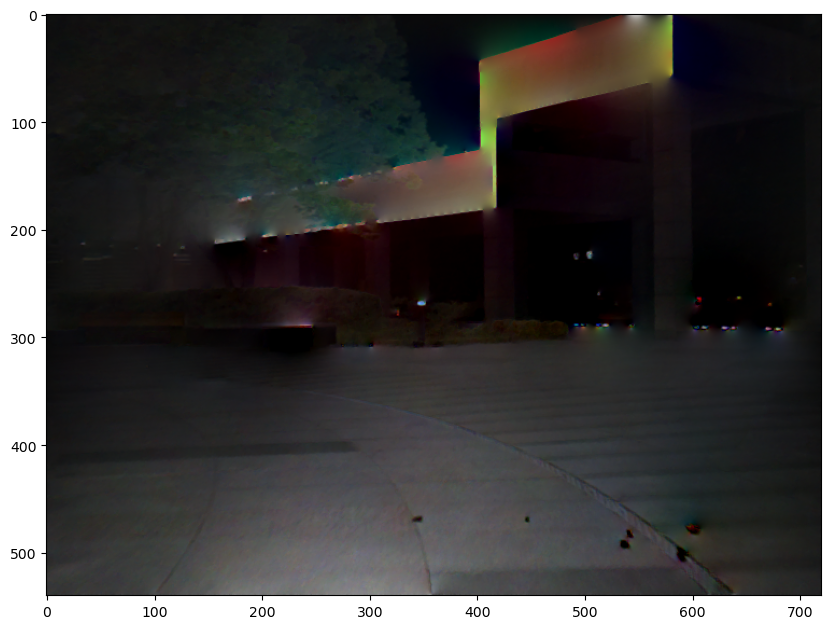

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


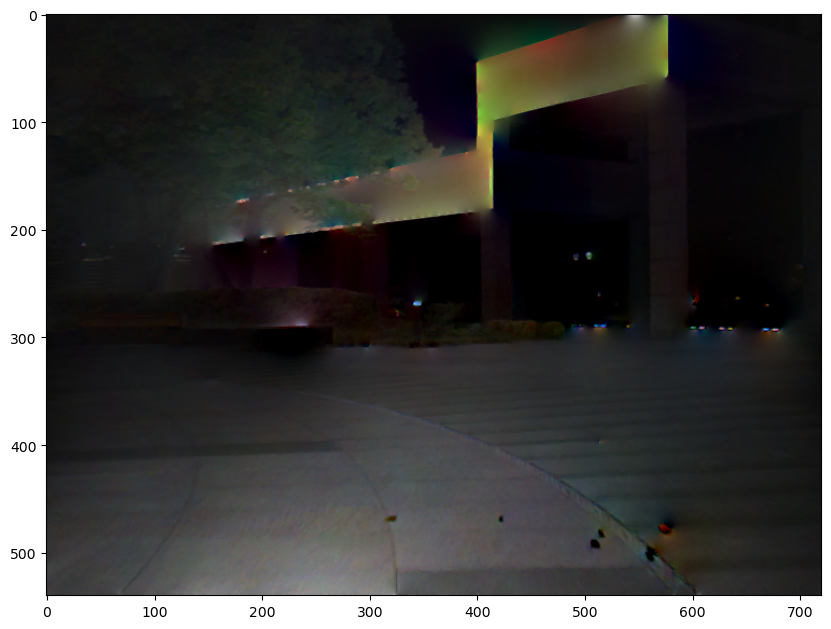

In [82]:
FOLDER = "/bean/depth/09-09-19-31-19/19_34_28_287"
def fuse_image(rgb, nir):
    rgb = rgb.astype(np.float32) / 255.0
    nir = nir.astype(np.float32) / 255.0
    #rgb_grad = compute_gradient(rgb)
    #nir_grad = compute_gradient(nir)
    rgb_grad = get_pixel_gradient(rgb, kernel_size=1)
    nir_grad = get_pixel_gradient(nir, kernel_size=1)
    rgb_jacobian = jacobian_matrix(rgb_grad)
    nir_jacobian = jacobian_matrix(nir_grad)
    weight = compute_gradient_weight(rgb_jacobian, nir_jacobian)
    rgb_grad_new = np.matmul(rgb_grad, weight)
    fused = poisson_reconstruct_gauss_seidel(rgb_grad_new, nir, iterations=10000)
    return fused


img_rgb_left = cv2.imread(FOLDER + "/rgb/left.png", cv2.IMREAD_COLOR_RGB)
img_rgb_right = cv2.imread(FOLDER + "/rgb/right.png", cv2.IMREAD_COLOR_RGB)
img_nir_left = cv2.imread(FOLDER + "/nir/left.png", cv2.IMREAD_GRAYSCALE)
img_nir_right = cv2.imread(FOLDER + "/nir/right.png", cv2.IMREAD_GRAYSCALE)

fused_left = fuse_image(img_rgb_left, img_nir_left).real
fused_right = fuse_image(img_rgb_right, img_nir_right).real
fused_left = fused_left / fused_left.max()
fused_right = fused_right / fused_right.max()
plt.figure(figsize=(10, 10))
plt.imshow(fused_left.cpu().numpy().real)
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(fused_right.cpu().numpy().real)
plt.show()

In [ ]:
try:
    from core.raft_stereo import RAFTStereo
except ImportError:
    import os
    os.chdir("/RAFT-Stereo")
    from core.raft_stereo import RAFTStereo
    
FRPASS = "frames_cleanpass"
from train_fusion.dataloader import StereoDataset, StereoDatasetArgs

import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
from fusion_args import FusionArgs
args = FusionArgs()
args.hidden_dims = [128, 128, 128]
args.corr_levels = 4
args.corr_radius = 4
args.n_downsample = 3
args.context_norm = "batch"
args.n_gru_layers = 2
args.shared_backbone = True
args.mixed_precision = True
args.corr_implementation = "reg_cuda"
args.slow_fast_gru = False
args.restore_ckpt = "models/raftstereo-realtime.pth"


args.lr = 0.001
args.train_iters = 7
args.valid_iters = 12
args.wdecay = 0.0001
args.num_steps = 100000
args.valid_steps = 1000
args.name = "StereoFusion"
args.batch_size = 4
args.fusion = "AFF"
args.shared_fusion = True
args.freeze_backbone = []
args.both_side_train= False
model = torch.nn.DataParallel(RAFTStereo(args)).cuda()
model.load_state_dict(torch.load(args.restore_ckpt))
model.eval()
model = model.module

In [79]:
def tensorfy(img):
    if isinstance(img, np.ndarray):
        
        if len(img.shape) == 2:
            img = img[:, :, np.newaxis]
            img = np.repeat(img, 3, axis=2)
        img = torch.from_numpy(img)
    if img.max() < 10:
        img *= 255
    return img.permute(2, 0, 1).float().unsqueeze(0).cuda()

def plot_frame(frame_folder:str, vmax=32):
    img_rgb_left = cv2.imread(frame_folder + "/rgb/left.png", cv2.IMREAD_COLOR_RGB)
    img_rgb_right = cv2.imread(frame_folder + "/rgb/right.png", cv2.IMREAD_COLOR_RGB)
    img_nir_left = cv2.imread(frame_folder + "/nir/left.png", cv2.IMREAD_GRAYSCALE)
    img_nir_right = cv2.imread(frame_folder + "/nir/right.png", cv2.IMREAD_GRAYSCALE)
    fused_left = fuse_image(img_rgb_left, img_nir_left).real
    fused_right = fuse_image(img_rgb_right, img_nir_right).real
    
    for pair in [(img_rgb_left, img_rgb_right),(img_nir_left, img_nir_right),(fused_left, fused_right)]:
        left, right = pair
        left = tensorfy(left)
        right = tensorfy(right)
        with torch.no_grad():
            _, flow = model(left, right, test_mode=True)
        disp = -flow[0,0].cpu().numpy()
        
        plt.figure(figsize=(10,3))
        sub = plt.subplot(1, 3, 1)
        sub.set_title("Left")
        plt.imshow(left[0].permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        sub = plt.subplot(1, 3, 2)
        sub.set_title("Right")
        plt.imshow(right[0].permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        sub = plt.subplot(1, 3, 3)
        sub.set_title("Disparity")
        cx = plt.imshow(disp, cmap='jet', vmin=0, vmax=vmax)
        plt.colorbar(cx)
        plt.show()
    

(540, 720, 3)
(540, 720)


100%|██████████| 1000/1000 [00:04<00:00, 222.68it/s]


(540, 720, 3)
(540, 720)


100%|██████████| 1000/1000 [00:04<00:00, 209.18it/s]


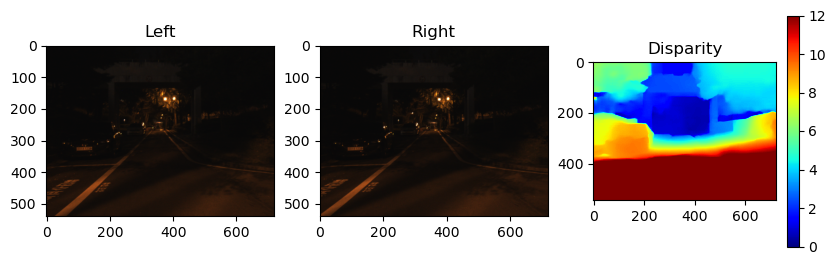

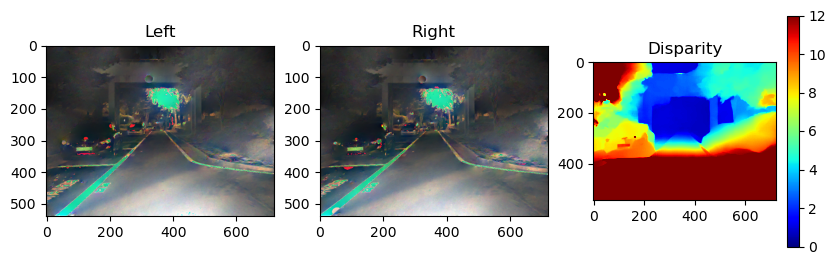

In [76]:
plot_frame("/bean/depth/09-09-20-04-34/20_09_39_935")

(540, 720, 3)
(540, 720)


100%|██████████| 1000/1000 [00:04<00:00, 205.95it/s]


(540, 720, 3)
(540, 720)


100%|██████████| 1000/1000 [00:04<00:00, 204.64it/s]


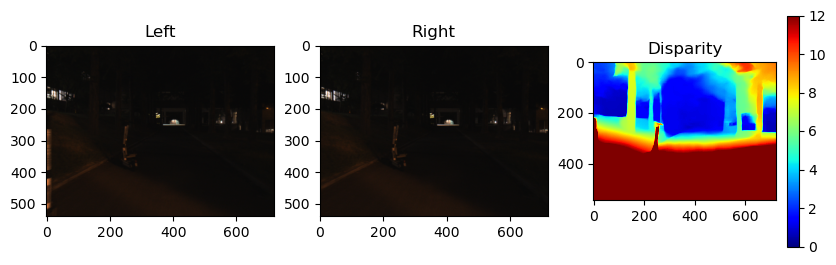

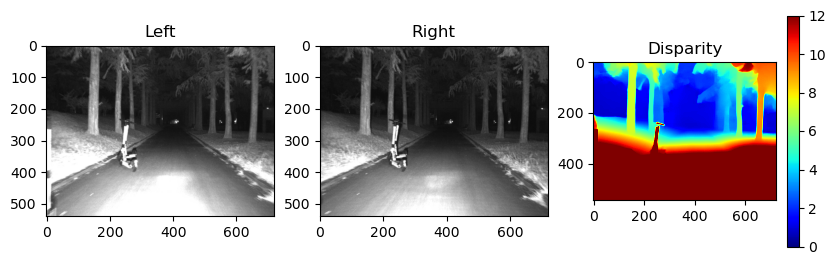

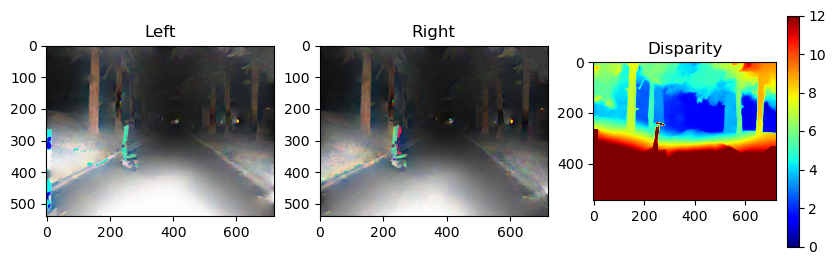

In [77]:
plot_frame("/bean/depth/09-09-20-04-34/20_09_49_602")

In [78]:
plot_frame("/bean/depth/09-09-20-04-34/20_11_44_768")

(540, 720, 3)
(540, 720)


100%|██████████| 1000/1000 [00:04<00:00, 203.95it/s]


(540, 720, 3)
(540, 720)


100%|██████████| 1000/1000 [00:04<00:00, 208.37it/s]


(540, 720, 3)
(540, 720)


100%|██████████| 1000/1000 [00:04<00:00, 208.78it/s]


(540, 720, 3)
(540, 720)


100%|██████████| 1000/1000 [00:04<00:00, 235.36it/s]


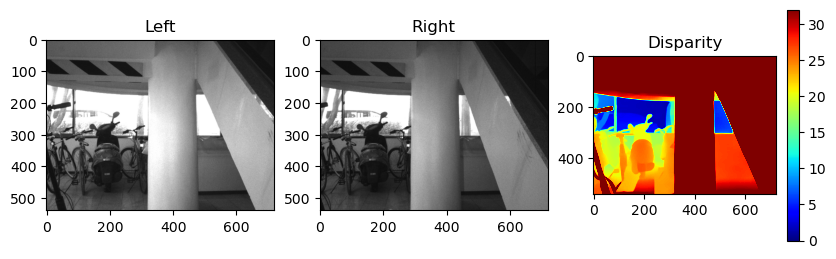

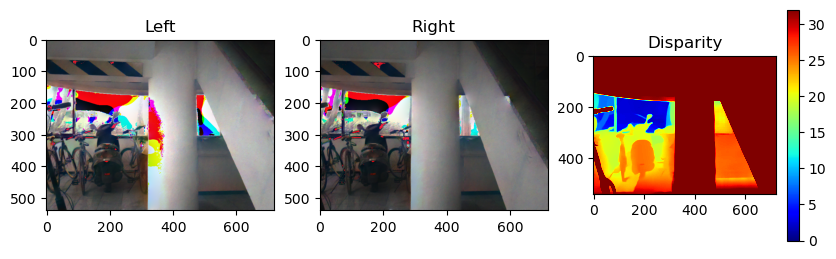

In [80]:
plot_frame("/bean/depth/09-20-13-50-44/13_51_01_097")

(540, 720, 3)
(540, 720)


100%|██████████| 10000/10000 [00:46<00:00, 215.27it/s]


(540, 720, 3)
(540, 720)


100%|██████████| 10000/10000 [00:49<00:00, 200.98it/s]


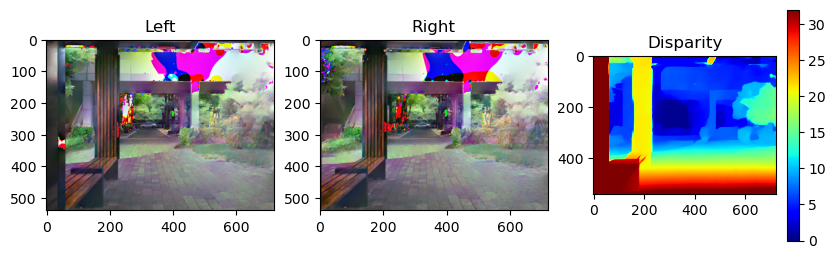

In [83]:
plot_frame("/bean/depth/09-05-17-34-15/17_34_14_935")

In [85]:
from train_fusion.my_h5_dataloader import MyH5DataSet
from torch.utils.data import DataLoader
import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
dataset = MyH5DataSet( frame_cache=True)
cnt = len(dataset)
train_cnt = int(cnt * 0.9)
valid_cnt = cnt - train_cnt
print(cnt)
dataset_train = MyH5DataSet(id_list = dataset.frame_id_list[:train_cnt])
dataset_valid = MyH5DataSet(id_list = dataset.frame_id_list[train_cnt:])
train_loader = DataLoader(dataset_train, batch_size=args.batch_size, shuffle=True, num_workers=0, drop_last=True)
valid_loader = DataLoader(dataset_valid, batch_size=args.batch_size, shuffle=False, num_workers=0, drop_last=True)

100%|██████████| 369/369 [00:15<00:00, 24.28it/s]

34484


In [ ]:
from grad2rgb import UNetResNet


gradModel = UNetResNet()